# Tang History Database - Automated Excessiveness Test
*January 24, 2019*

The Tang History Database features OCR-scanned text from the original 1970's publications of both the Old and New Tang dynastic histories. The scanned text has been audited by East Asian Studies graduate students who, as of this writing, have in total audited 47% of the total number of characters within 148 chapters, out of the combined 320 biography chapters (other chapters may be audited at a later time). Though most of the characters in our dataset match the original text, there are still a numerous amount of audits made to correct errors in scanning. Among those audits are a number of redundancies that were solved with an automated process.

*The process by which the list of audits to automate was generated can be explored in the "Database - Automated Audits List" Jupyter notebook. In brief, twenty of the most common audits were initially selected to test this process.*

The character replacement process (executed within the database) was extremely effective, adding 39,996 audits to the 19,243 submitted by the students. This is an increase of **307.84%**, reaching a total of **59,239** audits. Even so, a potential over-reach of automation may occur with a feature of Chinese characters known as "variants," small differences in the strokes of a character that can denote either a change of style (為 - 爲) or even a change of meaning. Auditing a character and replacing it with another in most cases will only be for stylistic purposes; however, because the list of audits generated for automation was derived by submissions from student workers, it is possible that some characters were replaced for one specific purpose and therefore not to be replaced as a whole across the entire text.

This test is designed to provide context for the audits performed by the automated process and to detect whether any audits were incorrectly performed.


## Selecting the groups to be examined
A "group" is a pair of characters—the original character ("Original") and the replacement character ("Modified"). Rather than examine all audited groups, the pairs with the highest percentage of audits performed by the automated process are examined. The process to acquire those groups is as follows:

1. Import the CSV document with all graduate student-submitted audits and ensure the import process was performed correctly.

In [113]:
import IPython.display
import pandas as pd

audPre = pd.read_csv(
    'AuditsOriginal20190109.csv',
    header=None,
    names=['Original','Modified']
)
audPre.head()

,Original,Modified
0,慎,愼
1,群,羣
2,慎,愼
3,儻,倘
4,賔,賓


2. Group the unique character pairs then grab the count of occurrences of each group and assign it to a new column ("Counts"), then grab the top 20 results.

In [114]:
audPre = (
    audPre.groupby(['Original','Modified']).size()
    .sort_values(ascending=False)
    .reset_index(name='Counts')
)
audPre.head(20)

,Original,Modified,Counts
0,為,爲,10859
1,即,卽,1102
2,尚,尙,882
3,衛,衞,685
4,賔,賓,370
5,鎮,鎭,329
6,群,羣,324
7,勑,敕,276
8,冊,册,269
9,真,眞,255


3. Import the CSV document with all audits post-automation  and ensure the import process was performed correctly.

In [115]:
audPost = pd.read_csv(
    'AuditsRevised20190114.csv',
    header=None,
    names=['Original','Modified']
)
audPost.head()

,Original,Modified
0,慎,愼
1,群,羣
2,慎,愼
3,儻,倘
4,賔,賓


4. Grab the count of occurrences of each group and assign it to a new column ("Counts"), then grab the top 20 results.

In [116]:
audPost = (
    audPost.groupby(['Original','Modified']).size()
    .sort_values(ascending=False)
    .reset_index(name='Counts')
)
audPost.head(20)

,Original,Modified,Counts
0,為,爲,29203
1,郎,郞,5540
2,尚,尙,5389
3,即,卽,3427
4,衛,衞,2294
5,鎮,鎭,2106
6,真,眞,1186
7,謚,諡,1134
8,并,幷,983
9,賔,賓,850


5. With both pre and post-automated audit lists imported, merge the two lists and set the pairs as the index.

In [117]:
audCompare = (
    pd.merge(
        audPre, audPost, on=['Original','Modified'], how='inner'
    )
    .rename(index=str, columns={
        'Counts_x':'Pre Count',
        'Counts_y':'Post Count'
    })
)
audCompare['Pairs'] = (
    audCompare['Original'] + "-" + audCompare['Modified']
)   
audCompare = (
    audCompare.set_index('Pairs')
    .drop(['Original','Modified'], axis=1)
)
audCompare.head(20)

,Pre Count,Post Count
Pairs,,
為-爲,10859,29203
即-卽,1102,3427
尚-尙,882,5389
衛-衞,685,2294
賔-賓,370,850
鎮-鎭,329,2106
群-羣,324,621
勑-敕,276,473
冊-册,269,579


6. From that, calculate the percentage change between pre and post-automation using the following formula:

$${Pre Count \over Post Count} = \% Change$$

Then list the results in order of percentage and grab the first five results.

In [118]:
audCompare['% Change'] = (
    audCompare['Post Count'].divide(audCompare['Pre Count'])
    .round(4) * 100
)
audCompare = (
    audCompare[audCompare['% Change'] > 100.0]
    .sort_values('% Change', ascending=False)
)
audCompare.head()

,Pre Count,Post Count,% Change
Pairs,,,
郎-郞,140,5540,3957.14
謚-諡,124,1134,914.52
鎮-鎭,329,2106,640.12
尚-尙,882,5389,611.00
并-幷,172,983,571.51


The five pairs with the greatest percentage of change between pre and post-automation are the result. These groups that will be examined in this test.

---

# Defining requisite functions

Included below are the Python fuctions necessary for this process. Comments are included for necessary context.

In [119]:
import IPython.display
import pandas as pd
import numpy as np

# The initial variable holding pairs of characters being analyzed,
# as well as the dictionaries that will be used to contain DataFrames
# related to each pair of characters. Those DataFrames will then be
# used to display the results of each function.

characterPairs = audCompare.index[:5] # The first five character pairs
group = {} # Referenced in function: pairImport
userCounts = {} # Referenced in function: metricCounts
mutualChap = {} # Referenced in function: sharedChap

def sharedChap(i):
    '''Generate table of audited chapters shared between
    server and students.'''
    
    # The auditGroup DataFrame contains counts of audits per 
    # both chapter and user.
    
    auditGroup = (
        group[i].groupby(['Chapter','Username']).size()
        .reset_index(name='audit counts')
    )
    
    # The uniqueUsers list contains the names of users who submitted
    # audits for a particular pair of characters (group).
    # If the first user in the list is not "server," the values are
    # swapped to accommodate for displaying the automated process
    # first in all reports.
    
    uniqueUsers = group[i].Username.unique().tolist()
    
    if uniqueUsers[0] != 'server':
        a = uniqueUsers.index('server')
        uniqueUsers[0], uniqueUsers[a] = uniqueUsers[a], uniqueUsers[0]
    
    # The splitGroup dictionary holds DataFrames containing the audit
    # counts and chapters for a specific user.
    
    splitGroup = {}
    k = 0
    
    for u in uniqueUsers:
        splitGroup[k] = (
            auditGroup.loc[auditGroup['Username'] == u]
            [['Chapter','audit counts']]
        )
        k += 1

    # The merged dictionary holds DataFrames that are merged with
    # inner join to throw away any rows that are not shared between
    # the server and the user's list of audited chapters.
    
    merged = {}
    m = 1
    
    while ( m < k ):
        merged[m] = (
            splitGroup[0].merge(
                splitGroup[m], 
                on='Chapter', 
                suffixes=(
                    f'_{uniqueUsers[0]}',
                    f'_{uniqueUsers[m]}'
                )
            )
            .set_index('Chapter')
        )
        
        m += 1
    
    # The mutualChap dictionary is then filled with the group's
    # concatenated DataFrame with all user's audits counts compared
    # with the server's own list, producing the desired report.
    # All NaN's are replaced with zeroes, converted to integers,
    # and then replaced with blank values for easier visibility.
    
    mutualChap[i] = (
        pd.concat(merged, sort=False)
        .fillna(0)
        .astype(int)
    )
    
    # The resulting dictionary entry is then displayed to the user.
    
    display(mutualChap[i])    

def metricCounts(i):
    '''Generate counts of chapters and audits per user.'''
    
    # The userCounts dictionary is assigned a DataFrame that includes
    # counts of each audited chapter per user, and total number of
    # audits per user, with appropriate column labels.
    
    userCounts[i] = (
        group[i]
        .groupby(['Chapter','Username'])['Paragraph'].agg('count')
        .reset_index(name='audit count')
        .groupby('Username')['audit count'].agg(['count','sum'])
        .rename(index=str,
                columns={'count':'chapter count', 'sum':'audit count'}
               )
    )
    
    # A new row is added to the DataFrame to display the percentage
    # of chapters audited by users, and of users' combined audits.
    
    userCounts[i].loc['Student % of Total'] = (0.0)
    userCounts[i].loc['Student % of Total'].at['chapter count'] = (
        (
            userCounts[i].iloc[1:,0].sum()
            / group[i].Chapter.nunique()
        )
        .round(3) * 100
    )
    userCounts[i].loc['Student % of Total'].at['audit count'] = (
        (
            userCounts[i].iloc[1:,1].sum()
            / userCounts[i].loc[:,'audit count'].sum()
        )
        .round(3) * 100
    )
    
    # The resulting dictionary entry is then displayed to the user.
    
    display(userCounts[i])

def pairImport(i):
    '''Import the appropriate CSV file to the group dictionary.'''
    
    group[i] = pd.read_csv(
        'AuditGroup{}-{}.csv'.format(i + 1, characterPairs[i]),
        header=None,
        names=['Original','Modified','Chapter','Paragraph','Username']
    )

Also necessary is the code for producing swarmplot charts for each audit group.

In [120]:
# For producing charts the following modules are imported.
    
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.patches as patches
from math import ceil
%matplotlib inline

prop = fm.FontProperties(
    fname = '../Chinese Fonts/Exported Fonts' \
    '/LiHei Pro/LiHeiPro.ttf', size=20
)

def chartGroup (i):
    '''Generate swarmplots for chapters with a significant 
    number of mutual audits.'''
    
    if len(mutualChap[i]) != 0:

        # Reserve the column and user name for the server, to be used
        # in all generated charts.

        sColumnName = mutualChap[i].columns[0]
        sName = sColumnName.split('_', 1)[1]

        # Save the total number of columns (users) to a variable.

        columnCount = len(mutualChap[i].columns)

        # Set the initial plot parameters and title.

        fig = plt.figure()
        fig.suptitle(
            f'Excessiveness Test Group {i + 1}: {characterPairs[i]}', 
            y = 1.05, 
            fontproperties = prop
        )
        fig.text(0.5, 0, 'usernames', ha='center')

        # This loop creates a separate chart for each user in
        # comparison to the server.

        for x in range(1, columnCount):

            # The column and user name is reserved as their own variables.

            uColumnName = mutualChap[i].columns[x]
            uName = uColumnName.split('_', 1)[1]

            # Take the data of the server and the current user to be charted
            # to its own variable.

            charted = (mutualChap[i].loc[x][[sColumnName,uColumnName]]
                      .rename(index=str, columns={sColumnName: sName,
                                                  uColumnName: uName})
                      )

            # Draw the subplots and label y axis if first.

            ax = plt.subplot(1, columnCount-1, x)
            if x == 1:
                ax.set_ylabel('count of audits')
            sns.swarmplot(data = charted, 
                          palette = dict(
                              server = '#3c5ca0', 
                              soojungh = '#b53840', 
                              lilix = '#479a55',
                              yuzhoub = '#d36f42',
                              yxiao = '#6d5ba4',
                              zhumingy = '#6d5ba4')
                         )

            # For y-axis ticks, determine the maximum number of audits
            # for the charted pair, then divide by 10 and round up to
            # an integer to set its interval. Also add that number to the
            # maximum number to buffer the padding at the top of the chart.
        
            sMax = mutualChap[i].loc[x].max()[0]
            uMax = mutualChap[i].max()[x]
            maxValue = max(sMax, uMax)
            ceilMax = ceil(maxValue / 10)
            ax.set_yticks(np.arange(0,
                                    maxValue + ceilMax,
                                    ceilMax
                                    )
                         )

            # In cases where the server replaced three or more characters
            # in a chapter, highlight the corresponding dots with a red box.

            if sMax > 3:
                rect = patches.Rectangle(
                    (-0.4, 3.5), 
                    width = 0.8, height = maxValue - ceilMax / 2,
                    linewidth = 1, edgecolor = 'r', facecolor = 'none')
                ax.add_patch(rect)

        plt.tight_layout()
    

    else:
        print(f'Nothing to report for pair {i+1}.')

## Group 1 郎-郞

*The instructions and code for processes in this group are included below as well as the first five records in the data, but this information will be omitted in future groups to prevent redundant reporting.*

1. Import the CSV document containing one pair of audited characters (original: 郎 and modified: 郞), and label columns correctly. The Username column contains either the account name of a graduate student or "server," representing audits made by the automated process.

In [121]:
pairImport(0)
group[0].head()

,Original,Modified,Chapter,Paragraph,Username
0,郎,郞,XTS 215a — 卷二百一十五上 列傳第一百四十上 突厥上,24,soojungh
1,郎,郞,XTS 215a — 卷二百一十五上 列傳第一百四十上 突厥上,24,soojungh
2,郎,郞,XTS 215a — 卷二百一十五上 列傳第一百四十上 突厥上,25,soojungh
3,郎,郞,XTS 215a — 卷二百一十五上 列傳第一百四十上 突厥上,34,soojungh
4,郎,郞,XTS 215a — 卷二百一十五上 列傳第一百四十上 突厥上,34,soojungh


2. "Describe" the data. This can provide particularly useful pieces of information, in particular (in order of row/column):
    1. (row: count) The total count of audits featuring this pair of characters
    2. (unique/Original and Modified columns) Only 1 unique character in both Original and Modified columns (meaning only one set of characters was examined in the data, assuring it has been retreived from the Tang History Database successfully)
    3. (unique/Chapter) The total number of chapters that contain the characters (out of 320 total)
    4. (unique/username) The count of users who have entered the audits (there will always be two or more: one being the graduate student entering the initial audit and the server itself automating the replacements)
    5. (top/Chapter) The chapter with the most amount of audits of this character (in regards to database use, not so much for this report)

In [122]:
group[0].describe(include='O')

,Original,Modified,Chapter,Username
count,5540,5540,5540,5540
unique,1,1,312,2
top,郎,郞,JTS 177 — 卷一百七十七 列傳第一百二十七,server
freq,5540,5540,130,5400


In this instance, the most relevant details are:

- The character has been audited in almost all chapters.
- Only the server and one graduate student have made audits on this character, meaning that while it has appeared in chapters audited by other graduate students, those students did not correct it. This could be because of specific instructions given to skip the character.
- Only one Original and one Modified character are examined in this data (this has been mentioned previously, but this metric is crucial to the accuracy of the process).

3. See how many audits were submitted by each user, and how many chapters they audited that included the character. This information—incomplete due to only half the chapters being audited by the graduate students—shares a perspective on how much work has been saved by the automated process.

In [123]:
metricCounts(0)

,chapter count,audit count
Username,,
server,293.0,5400.0
soojungh,22.0,140.0
Student % of Total,7.1,2.5


In this case, the server prevented "soojungh" and the other students from auditing **5,400** other occurrences of this character, which means **the student had only entered 2.5%** of the total number of this character's appearance across the histories.

4. Obtain a list of all chapters with audits made by both the graduate student(s) and the server. This is crucial because the server would only replace characters in these chapters if the graduate student either didn't spot them or deemed them unnecessary. It is the latter possibility that concerns this test, because if the graduate student didn't find it necessary, the automated process may have done it extraneously.

In [124]:
sharedChap(0)

audit counts_server  \
  Chapter                                                   
1 JTS 196b — 卷一百九十六下   列傳第一百四十六下 吐蕃下                    1   
  XTS 219 — 卷二百一十九   列傳第一百四十四 北狄                        1   
  XTS 221a — 卷二百二十一上   列傳第一百四十六上 西域上                    1   

                                      audit counts_soojungh  
  Chapter                                                    
1 JTS 196b — 卷一百九十六下   列傳第一百四十六下 吐蕃下                      7  
  XTS 219 — 卷二百一十九   列傳第一百四十四 北狄                          5  
  XTS 221a — 卷二百二十一上   列傳第一百四十六上 西域上                      9

With each group a chart will be generated to visualize the chapters in which both the student and the automated process entered character replacements. What we want to see in the corresponding charts are the blue dots of the server (the automated process) in low numbers with the student in high numbers. This indicates that the server did not have to replace as much because the student audited most of them. An example of an ideal situation is with the chart below.

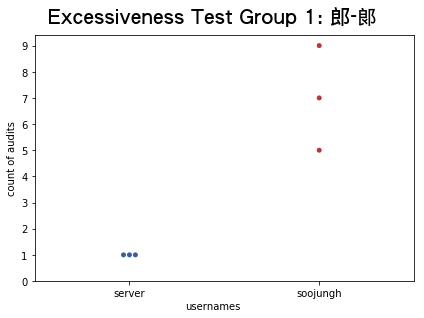

In [125]:
chartGroup(0)

This first group has only three chapters where both the student and server made audits, and the server only replaced one character in each. An assumption can be made that the student missed these characters because they were able to detect the majority of the other occurrences, and this is only **3 out of the 22 chapters** the graduate student audited.

### Conclusion - Group 1 郎-郞

The character pair of 郎-郞 had the highest disparity (3,957.14%) between student-submitted audits and server-submitted audits, causing concern over its accuracy, especially considering:
* The audits took place in 312 out of 320 total chapters.
* Only one graduate student submitted this audit, leaving the server to submit **97.5%** of the total audits.

However, there isn't enough evidence to say any were made by mistake because:
* Out of the 23 chapters the graduate student audited, they only missed 3 occurrences of the character.
* Also, "soojungh" started on the project months later after we had already suggested skipping the submission of redundant audits to the other students.

Therefore, we can conclude that this pair **does** ***not*** **need further review.**

---

## Group 2 謚-諡

In [126]:
pairImport(1)

In [127]:
group[1].describe(include='O')

,Original,Modified,Chapter,Username
count,1134,1134,1134,1134
unique,1,1,246,2
top,謚,諡,XTS 076 — 卷七十六 列傳第一 后妃上,server
freq,1134,1134,27,1010


Relevant notes to these results:
- As with Group 1, only the server and one student submitted audits of this character pair.
- The number of occurrences of this pair is only 20% of the number of audits from the previous group...
- But it appears in 77% of the total number of chapters...
- Which means it is a very widespread character, even if it doesn't appear as much in the text.

In [128]:
metricCounts(1)

,chapter count,audit count
Username,,
server,221.0,1010.0
yuzhoub,26.0,124.0
Student % of Total,10.6,10.9


The server prevented "yuzhoub" and the other students from auditing **1,010** other occurrences of this character, which means **the student had only entered 10.9%** of the total number of this character's appearance across the histories.

In [129]:
sharedChap(1)

,,audit counts_server,audit counts_yuzhoub
,Chapter,,
1,JTS 086 — 卷八十六 列傳第三十六 高宗中宗諸子,1,7


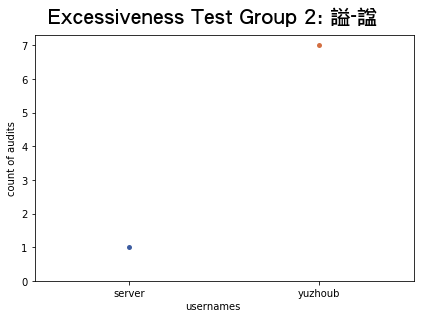

In [130]:
chartGroup(1)

With this group, "yuzhoub" missed only 1 character and **submitted 124 instances of this character pair in 26 chapters.**

### Conclusion - Group 2 謚-諡

The character pair of 謚-諡 was the second-highest disparity (914.52%), and is not at risk of unintentional audits because:
* This pair occurred only 1,134 times, compared to 5,540 with Group 1. 
* The audits took place in 246 out of 320 total chapters, compared to 312 with Group 1.
* Even with only one student submitting this audit, the server submitted 89.1% of the total audits, as compared to 97.5% with Group 1.

It is safe to assume this group **does** ***not*** **need further review** because:
* The student submitted more than 10% of the total audits, which is a good sample size of all occurrences of this character. 
* They only missed one instance in 26 assigned chapters, which is 10.6% of all chapters including the character. They audited their text with high accuracy, but more importantly *it is extremely likely that all occurrences of that character were meant to be substituted with the new character.*

---

## Group 3 鎮-鎭

In [131]:
pairImport(2)

In [132]:
group[2].describe(include='O')

,Original,Modified,Chapter,Username
count,2106,2106,2106,2106
unique,1,1,284,3
top,鎮,鎭,JTS 142 — 卷一百四十二 列傳第九十二 李寶臣,server
freq,2106,2106,50,1777


Relevant notes for these results:
- Though it is only roughly 40% as large as the largest group...
- This group appears in 89% of the total number of chapters.
- Two students submitted audits with this character pair, as well as the server.

In [133]:
metricCounts(2)

,chapter count,audit count
Username,,
server,236.0,1777.0
soojungh,22.0,145.0
yuzhoub,41.0,184.0
Student % of Total,22.2,15.6


The server prevented the auditing of **1,777** other occurrences of this character, which means **the students entered 15.6% combined** of the total number of this character's appearance across the histories. The students also audited 22.2% of the 284 chapters that included the character, an even better sample size.

In [134]:
sharedChap(2)

audit counts_server  \
  Chapter                                                            
1 JTS 196a — 卷一百九十六上   列傳第一百四十六上 吐蕃上                             3   
  JTS 196b — 卷一百九十六下   列傳第一百四十六下 吐蕃下                             2   
  XTS 216b — 卷二百一十六下   列傳第一百四十一下 吐蕃下                             1   
  XTS 217b — 卷二百一十七下   列傳第一百四十二下 回鶻下                             1   
  XTS 218 — 卷二百一十八   列傳第一百四十三 沙陀                                 2   
2 JTS 089 — 卷八十九   列傳第三十九 狄仁傑                                    3   
  JTS 091 — 卷九十一   列傳第四十一                                        2   
  JTS 093 — 卷九十三   列傳第四十三                                        2   
  JTS 095 — 卷九十四   列傳第四十四 睿宗諸子                                   1   
  JTS 097 — 卷九十七   列傳第四十七 劉幽求　鍾紹京　郭元振　張說                         1   
  JTS 104 — 卷一百零四   列傳第五十四                                       1   
  JTS 110 — 卷一百一十   列傳第六十                                        1   
  JTS 114 — 卷一百一十四   列傳第六十四                                      1   
  XTS 116 — 卷一百一十六   列傳第四十一                                      1   
  XTS 120 — 卷一百二十   列傳第四十五 桓彥範　敬暉　崔玄暐　張柬之　袁恕己                    1   

                                               audit counts_soojungh  \
  Chapter                                                              
1 JTS 196a — 卷一百九十六上   列傳第一百四十六上 吐蕃上                              12   
  JTS 196b — 卷一百九十六下   列傳第一百四十六下 吐蕃下                              11   
  XTS 216b — 卷二百一十六下   列傳第一百四十一下 吐蕃下                               8   
  XTS 217b — 卷二百一十七下   列傳第一百四十二下 回鶻下                               4   
  XTS 218 — 卷二百一十八   列傳第一百四十三 沙陀                                  11   
2 JTS 089 — 卷八十九   列傳第三十九 狄仁傑                                      0   
  JTS 091 — 卷九十一   列傳第四十一                                          0   
  JTS 093 — 卷九十三   列傳第四十三                                          0   
  JTS 095 — 卷九十四   列傳第四十四 睿宗諸子                                     0   
  JTS 097 — 卷九十七   列傳第四十七 劉幽求　鍾紹京　郭元振　張說                           0   
  JTS 104 — 卷一百零四   列傳第五十四                                         0   
  JTS 110 — 卷一百一十   列傳第六十                                          0   
  JTS 114 — 卷一百一十四   列傳第六十四                                        0   
  XTS 116 — 卷一百一十六   列傳第四十一                                        0   
  XTS 120 — 卷一百二十   列傳第四十五 桓彥範　敬暉　崔玄暐　張柬之　袁恕己                      0   

                                               audit counts_yuzhoub  
  Chapter                                                            
1 JTS 196a — 卷一百九十六上   列傳第一百四十六上 吐蕃上                              0  
  JTS 196b — 卷一百九十六下   列傳第一百四十六下 吐蕃下                              0  
  XTS 216b — 卷二百一十六下   列傳第一百四十一下 吐蕃下                              0  
  XTS 217b — 卷二百一十七下   列傳第一百四十二下 回鶻下                              0  
  XTS 218 — 卷二百一十八   列傳第一百四十三 沙陀                                  0  
2 JTS 089 — 卷八十九   列傳第三十九 狄仁傑                                     5  
  JTS 091 — 卷九十一   列傳第四十一                                         2  
  JTS 093 — 卷九十三   列傳第四十三                                        10  
  JTS 095 — 卷九十四   列傳第四十四 睿宗諸子                                    1  
  JTS 097 — 卷九十七   列傳第四十七 劉幽求　鍾紹京　郭元振　張說                         21  
  JTS 104 — 卷一百零四   列傳第五十四                                        8  
  JTS 110 — 卷一百一十   列傳第六十                                         3  
  JTS 114 — 卷一百一十四   列傳第六十四                                       9  
  XTS 116 — 卷一百一十六   列傳第四十一                                       2  
  XTS 120 — 卷一百二十   列傳第四十五 桓彥範　敬暉　崔玄暐　張柬之　袁恕己                     2

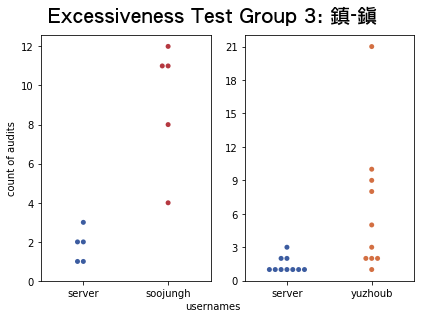

In [135]:
chartGroup(2)

It is suspicious to see many more chapters shared between the server and the grad students, but with low totals in each chapter, it is safe to assume human error, especially if there are multiple instances of the audit taking place in one particular paragraph.

Also, it is worth taking into account how similar in appearance both characters are. Even though the characters do not appear small in the auditing feature of the database, 鎮-鎭 is still easy to overlook.

### Conclusion - Group 3 鎮-鎭

The character pair of 鎮-鎭 is the third-highest disparity (640.12%), and is *slightly* at risk of unintentional audits because:
* The audits occurred 2,106 times and took place in 284 out of 320 total chapters, compared to 312 with Group 1.
* There are a greater number of chapters where both students and the server replaced characters, signaling the possiblity of a pattern where characters were left alone on purpose.

It is safe to assume, however, this group **does** ***not*** **need further review** because:
* The student submitted more than 10% of the total audits without issue, which is a good sample size of all occurrences of this character. 
* The characters are complicated in shape and easy to overlook.

---

## Group 4 尚-尙

In [136]:
pairImport(3)

In [137]:
group[3].describe(include='O')

,Original,Modified,Chapter,Username
count,5389,5389,5389,5389
unique,1,1,320,4
top,尚,尙,JTS 177 — 卷一百七十七 列傳第一百二十七,server
freq,5389,5389,90,4507


Relevant notes for these results:
- This is the second-highest amount of audits, with 97% as many as Group 1.
- This group appears in **all 320 biography chapters.**
- **Three students** submitted audits with this character pair, as well as the server.

In [138]:
metricCounts(3)

,chapter count,audit count
Username,,
server,285.0,4507.0
soojungh,23.0,222.0
yuzhoub,45.0,659.0
yxiao,1.0,1.0
Student % of Total,21.6,16.4


The server prevented the auditing of **4,507** other occurrences of this character, which means **the students entered 16.4%** of the total number of this character's appearance across the histories. The students also audited the highest percentage of chapters with this pair at **21.6%**.

In [139]:
sharedChap(3)

audit counts_server  \
  Chapter                                                            
1 JTS 196a — 卷一百九十六上   列傳第一百四十六上 吐蕃上                             1   
  JTS 196b — 卷一百九十六下   列傳第一百四十六下 吐蕃下                             2   
2 JTS 092 — 卷九十二   列傳第四十二 魏元忠　韋安石                               48   
  JTS 093 — 卷九十三   列傳第四十三                                        6   
  JTS 094 — 卷九十四   列傳第四十四                                        2   
  JTS 095 — 卷九十四   列傳第四十四 睿宗諸子                                   1   
  JTS 096 — 卷九十六   列傳第四十六                                        4   
  JTS 097 — 卷九十七   列傳第四十七 劉幽求　鍾紹京　郭元振　張說                         4   
  JTS 098 — 卷九十八   列傳第四十八                                        6   
  JTS 099 — 卷九十九   列傳第四十九                                        3   
  JTS 100 — 卷一百   列傳第五十                                          5   
  JTS 101 — 卷一百零一   列傳第五十一                                       5   
  JTS 102 — 卷一百零二   列傳第五十二                                       3   
  JTS 103 — 卷一百零三   列傳第五十三                                       2   
  JTS 105 — 卷一百零五   列傳第五十五                                       2   
  JTS 107 — 卷一百零七   列傳第五十七 玄宗諸子                                  1   
  JTS 108 — 卷一百零八   列傳第五十八 韋見素                                   1   
  JTS 110 — 卷一百一十   列傳第六十                                        2   
  JTS 111 — 卷一百一十一   列傳第六十一 崔光遠　房琯                               3   
  JTS 113 — 卷一百一十三   列傳第六十三 苗晉卿　裴冕　裴遵慶                           1   
  JTS 115 — 卷一百一十五   列傳第六十五                                      1   
  JTS 116 — 卷一百一十六   列傳第六十六 肅宗代宗諸子                               1   
  JTS 119 — 卷一百一十九   列傳第六十九 楊綰　崔祐甫                               2   
  XTS 115 — 卷一百一十五   列傳第四十 狄仁傑　郝處俊　朱敬則                           1   
  XTS 116 — 卷一百一十六   列傳第四十一                                      1   
  XTS 117 — 卷一百一十七   列傳第四十二 裴炎　劉禕之　魏玄同　李昭德　吉頊                    1   
  XTS 119 — 卷一百一十九   列傳第四十四 武平一　李乂　賈曾至　白居易                       2   
  XTS 120 — 卷一百二十   列傳第四十五 桓彥範　敬暉　崔玄暐　張柬之　袁恕己                    1   
  XTS 124 — 卷一百二十四   列傳第四十九 姚崇　宋璟                                1   
  XTS 126 — 卷一百二十六   列傳第五十一                                      2   
  XTS 128 — 卷一百二十八   列傳第五十三                                      1   
  XTS 130 — 卷一百三十   列傳第五十五                                       1   
  XTS 131 — 卷一百三十一   列傳第五十六 宗室宰相                                 1   
3 JTS 102 — 卷一百零二   列傳第五十二                                       3   

                                               audit counts_soojungh  \
  Chapter                                                              
1 JTS 196a — 卷一百九十六上   列傳第一百四十六上 吐蕃上                              15   
  JTS 196b — 卷一百九十六下   列傳第一百四十六下 吐蕃下                              29   
2 JTS 092 — 卷九十二   列傳第四十二 魏元忠　韋安石                                  0   
  JTS 093 — 卷九十三   列傳第四十三                                          0   
  JTS 094 — 卷九十四   列傳第四十四                                          0   
  JTS 095 — 卷九十四   列傳第四十四 睿宗諸子                                     0   
  JTS 096 — 卷九十六   列傳第四十六                                          0   
  JTS 097 — 卷九十七   列傳第四十七 劉幽求　鍾紹京　郭元振　張說                           0   
  JTS 098 — 卷九十八   列傳第四十八                                          0   
  JTS 099 — 卷九十九   列傳第四十九                                          0   
  JTS 100 — 卷一百   列傳第五十                                            0   
  JTS 101 — 卷一百零一   列傳第五十一                                         0   
  JTS 102 — 卷一百零二   列傳第五十二                                         0   
  JTS 103 — 卷一百零三   列傳第五十三                                         0   
  JTS 105 — 卷一百零五   列傳第五十五                                         0   
  JTS 107 — 卷一百零七   列傳第五十七 玄宗諸子                                    0   
  JTS 108 — 卷一百零八   列傳第五十八 韋見素                                     0   
  JTS 110 — 卷一百一十   列傳第六十                                          0   
  JTS 111 — 卷一百一十一   列傳第六十一 崔光遠　房琯                                 0   
  JTS 113 — 卷一

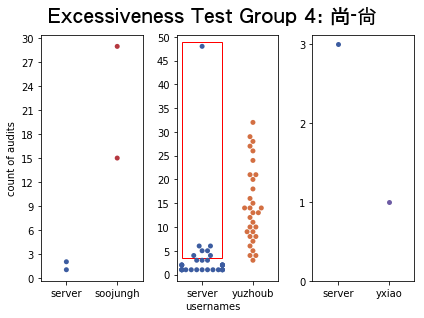

In [140]:
chartGroup(3)

If it was merely suspicious with previous groups to see a significant number of chapters shared between the graduate students and the server, a list this large is *especially concerning.*

Most of the chapters have low server replacements with the exception of "yuzhoub." One of their chapters has an extremely high count, in comparison to the average of 2-3, and other chapters also above the average, as well.

### Conclusion - Group 4 尚-尙

With a disparity of 611%, Group 4 (尚-尙) initially had the highest potential for erroneously replacements because:
* The character pair appeared in all biography chapters and reached 97% of the total of Group 1's occurrences.
* There are a greater number of chapters where both students and the server replaced characters, signaling the possiblity of a pattern where characters were left alone on purpose.
* "yuzhoub" had an extremely high number of server replacements, much higher than the average.

This group **needs further review** because:
* "yuzhoub" has had very high accuracy with other characters, which could signal not replacing the characters for a specific purpose.
* The characters are not as complicated in shape as other character pairs.

---

## Group 5 并-幷

In [141]:
pairImport(4)

In [142]:
group[4].describe(include='O')

,Original,Modified,Chapter,Username
count,983,983,983,983
unique,1,1,263,2
top,并,幷,XTS 215a — 卷二百一十五上 列傳第一百四十上 突厥上,server
freq,983,983,20,811


Relevant notes to these results:
- Only the server and one student submitted audits of this character pair.
- This group has a relatively low number of occurrences across chapters when compared to the other groups.
- It is, however, also a very widespread character, appearing in 82.2% of the total number of chapters.

In [143]:
metricCounts(4)

,chapter count,audit count
Username,,
server,247.0,811.0
soojungh,23.0,172.0
Student % of Total,8.7,17.5


The server prevented the auditing of **811** other occurrences of this character, which means **the student entered 17.5% combined** of the total number of this character's appearance across the histories. The student, however, only audited 8.7% of the chapters in which this character appeared, which is not a large sample size.

In [144]:
sharedChap(4)

audit counts_server  \
  Chapter                                                   
1 JTS 194b — 卷一百九十四下   列傳第一百四十四下 突厥下                    1   
  JTS 196b — 卷一百九十六下   列傳第一百四十六下 吐蕃下                    2   
  JTS 197 — 卷一百九十七   列傳第一百四十七                           1   
  JTS 198 — 卷一百九十八   列傳第一百四十八 西戎                        1   
  XTS 216a — 卷二百一十六上   列傳第一百四十一上 吐蕃上                    2   
  XTS 216b — 卷二百一十六下   列傳第一百四十一下 吐蕃下                    1   
  XTS 222c — 卷二百二十二下   列傳第一百四十七下 南蠻下                    1   

                                      audit counts_soojungh  
  Chapter                                                    
1 JTS 194b — 卷一百九十四下   列傳第一百四十四下 突厥下                      6  
  JTS 196b — 卷一百九十六下   列傳第一百四十六下 吐蕃下                     11  
  JTS 197 — 卷一百九十七   列傳第一百四十七                             5  
  JTS 198 — 卷一百九十八   列傳第一百四十八 西戎                         11  
  XTS 216a — 卷二百一十六上   列傳第一百四十一上 吐蕃上                      8  
  XTS 216b — 卷二百一十六下   列傳第一百四十一下 吐蕃下                      5  
  XTS 222c — 卷二百二十二下   列傳第一百四十七下 南蠻下                      4

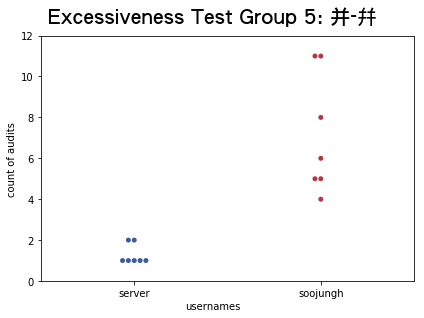

In [145]:
chartGroup(4)

There are more chapters here listed with audits from both the server and student as compared to Groups 1 & 2, however all server replacements counts are low, which is not signaling much significance.

### Conclusion - Group 5 并-幷

Group 5 has the lowest disparity (571.51%) and as expected had little risk of excessive auditing because:
- The character appeared less than 1,000 times across 263 chapters.

This group **does** ***not*** **need further review** because:
- The characters are extremely similar and easy to miss (并-幷).
- The server submitted a low count of audits in chapters where the student performed their own audits.

---

## Conclusion of the Audit Group Excessiveness Test
### Group 4 尚-尙 is the only group of audits that could benefit from further review due to its high number of occurrences and chapters containing both a high number of student and server replacements.